In [1]:
import sys        
sys.path.append('/home/huyentn2/project/nano_count/segmentation_unet/')
import os
from dataset import *
from utils import *
import torch.nn.functional  as F
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from scipy.ndimage import label
from utils import get_num_NP
import matplotlib.pyplot as plt
import json


/home/huyentn2/.conda/envs/nano/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=1, n_classes= 2, bilinear= False)
model = model.to(memory_format=torch.channels_last)
model = torch.nn.DataParallel(model).cuda()

checkpoint = torch.load("/home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/fold0/checkpoint_epoch15.pth")

model.load_state_dict(checkpoint)
model.to(device=device)

input_dir = "/home/huyentn2/project/nano_count/segmentation_unet/data/img_patch/"
save_dir = "/home/huyentn2/project/nano_count/segmentation_unet"

out_files = "/home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/save_result/binary_pred/fold8/"
files = os.listdir(out_files)


In [3]:
js  = '/home/huyentn2/project/nano_count/segmentation_unet/inference/gt_all_count.json'

with open(js, 'r') as fp:
    gt_count = json.load(fp)

DIFFERENT BINARY THRESHOLD

In [4]:
count_GT = []

for id in range(len(files)):

    if files[id] in list(gt_count.keys()):
        count_GT.append(gt_count[files[id]])

In [5]:
min_dist = 10
max_fil_thr = 120
bin_thr_range = np.arange(.5,.7,.05)
range_rad = (10,200)
type_count = "3" # 4

def plot(type_count):
    count_3 = np.zeros((len(bin_thr_range), len(files)))

    for id in range(len(files)):
        input_file = input_dir + files[id]
        mask_pred = eval_single_count(input_file,
                    save_dir,
                    model,
                    device,
                    img_scale=1.0,)

        # count_list = []
        for i in range(len(bin_thr_range)):
            bin_thr = bin_thr_range[i]
            num_PN = get_num_NP(mask_pred, min_dist=None, max_fil_thr =None, bin_thr = bin_thr,  range_rad= range_rad, type_count= type_count)
            # count_list.append(num_PN)
            try:
                count_3[i, id] = num_PN
            except ValueError:
                count_3[i, id] = num_PN[0]

    count_3.shape

    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(0, len(count_GT)-1, len(count_GT))
    ax.plot(x, count_GT, 'r')
    for i in range(len(bin_thr_range)):
        # if i in [1,3,5,8]:
        ax.plot(x, count_3[i,:])

    err_mat = np.zeros((len(bin_thr_range)))
    for j in range(len(bin_thr_range)):
        err_mat[j] = np.sum(np.abs(count_3[j,:] - count_GT))

    return err_mat, count_3

    

/home/huyentn2/.conda/envs/nano/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


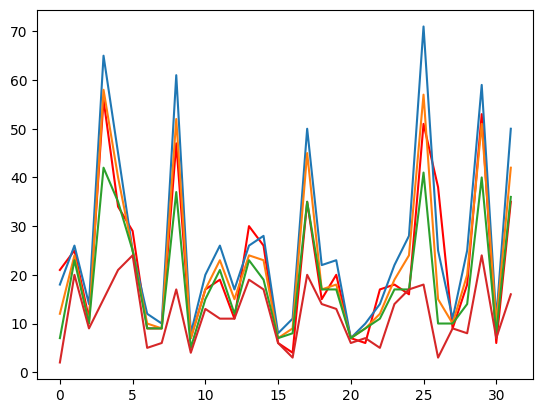

In [6]:
err_mat, count_3 = plot("4")

In [7]:
err_mat/35

array([5.62857143, 3.65714286, 4.2       , 9.34285714])

In [8]:
len(err_mat)
err_mat

array([197., 128., 147., 327.])

In [9]:
# fig = plt.figure()
# ax = plt.axes()
# x = np.linspace(0, len(count_GT)-1, len(count_GT))
# ax.plot(x, count_GT, 'r')
# for i in range(len(bin_thr_range)):
#     if i in [1,3,5,8]:
#         ax.plot(x, count_3[i,:])

(array([191., 129., 146., 320.]),
 array([[16., 26., 14., 66., 45., 25., 12., 10., 59.,  8., 20., 26., 17.,
         26., 29.,  8., 11., 51., 22., 20.,  7., 10., 13., 22., 25., 70.,
         25., 10., 24., 59., 11., 49.],
        [12., 24., 10., 58., 39., 25., 10.,  9., 52.,  7., 17., 23., 15.,
         24., 23.,  7.,  9., 45., 18., 18.,  7.,  9., 12., 20., 23., 57.,
         15., 10., 20., 50.,  9., 43.],
        [ 7., 23., 10., 43., 34., 25.,  9.,  9., 38.,  5., 15., 21., 13.,
         23., 20.,  7.,  8., 35., 17., 17.,  7.,  9., 11., 17., 17., 41.,
          9., 10., 13., 40.,  8., 36.],
        [ 2., 20.,  9., 17., 22., 24.,  5.,  7., 17.,  4., 13., 12., 11.,
         19., 17.,  6.,  3., 20., 14., 13.,  6.,  7.,  5., 14., 17., 19.,
          4.,  9.,  8., 24.,  7., 16.]]))

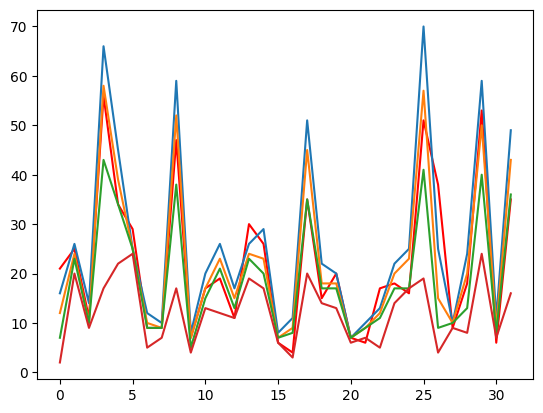

In [10]:
plot("3")

(array([191., 191., 191., 191.]),
 array([[18., 26., 14., 65., 45., 25., 12., 10., 59.,  8., 20., 26., 17.,
         26., 29.,  8., 11., 51., 22., 21.,  7., 10., 14., 22., 27., 71.,
         25., 10., 24., 59., 11., 49.],
        [18., 26., 14., 65., 45., 25., 12., 10., 59.,  8., 20., 26., 17.,
         26., 29.,  8., 11., 51., 22., 21.,  7., 10., 14., 22., 27., 71.,
         25., 10., 24., 59., 11., 49.],
        [18., 26., 14., 65., 45., 25., 12., 10., 59.,  8., 20., 26., 17.,
         26., 29.,  8., 11., 51., 22., 21.,  7., 10., 14., 22., 27., 71.,
         25., 10., 24., 59., 11., 49.],
        [18., 26., 14., 65., 45., 25., 12., 10., 59.,  8., 20., 26., 17.,
         26., 29.,  8., 11., 51., 22., 21.,  7., 10., 14., 22., 27., 71.,
         25., 10., 24., 59., 11., 49.]]))

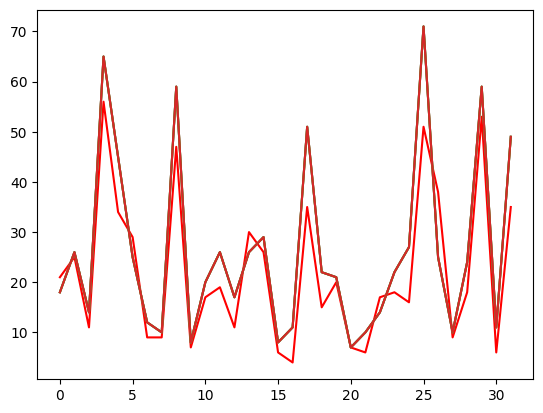

In [11]:
plot("2")

PLOT WITH DIFFERENT COUNTING METHOD

In [12]:
input_dir

# len(files)

'/home/huyentn2/project/nano_count/segmentation_unet/data/img_patch/'

In [13]:
out_files

'/home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/save_result/binary_pred/fold8/'

In [14]:
min_dist = 10
max_fil_thr = 120
bin_thr_ = 0.5
range_rad = (10,200)
# type_count = "3" # 4
labels = ["0", "1", "2", "3", "4"]

def plot_all_meth1():
    count_ = np.zeros((5, len(files)))

    for id in range(len(files)):
        input_file = input_dir + files[id]
        mask_pred = eval_single_count(input_file,
                    save_dir,
                    model,
                    device,
                    img_scale=1.0,)

        # count_list = []
        for i in range(5):
            type_count = str(i)
            num_PN = get_num_NP(mask_pred, min_dist=min_dist, max_fil_thr =max_fil_thr, bin_thr = bin_thr_,  range_rad= range_rad, type_count= type_count)
            # count_list.append(num_PN)
            try:
                count_[i, id] = num_PN
            except ValueError:
                # print(num_PN[0])
                # print(i)
                count_[i, id] = num_PN[0]


    count_.shape

    err_mat = np.zeros((5))
    for j in range(5):
        err_mat[j] = np.sum(np.abs(count_[j,:] - count_GT))


    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(0, len(count_GT)-1, len(count_GT))
    ax.plot(x, count_GT, 'r', label="ground_truth")
    for i in range(5):
        # if i in [1,3,5,8]:
        ax.plot(x, count_[i,:], label= labels[i] + ": " + "{0:.2f}".format(err_mat[i]/len(files)), linestyle='dashed')
        ax.legend()


    return err_mat, count_

    

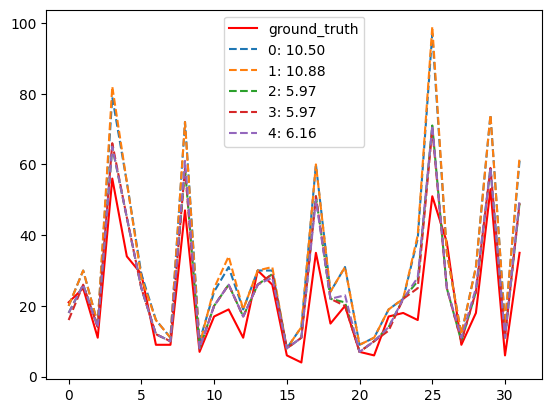

In [15]:
err_mat_, count_ =plot_all_meth1()

In [16]:
err_mat_/35

array([9.6       , 9.94285714, 5.45714286, 5.45714286, 5.62857143])

EVALUATION: NUM_COUNT_EACH_IMG/ TOTAL_GT_IMG

GET PLOT OF ALL FOLDS

In [23]:
min_dist = 10
max_fil_thr = 120
bin_thr_ = 0.5
range_rad = (10,200)
# type_count = "3" # 4
labels = ["0", "1", "2", "3", "4"]

def plot_all_meth(inp_dir, input_dir, save_dir, model, device):

    files = os.listdir(input_dir)

    count_GT = []

    for id in range(len(files)):
        if files[id] in list(gt_count.keys()):
            count_GT.append(gt_count[files[id]])

    count_ = np.zeros((5, len(files)))

    for id in range(len(files)):
        
        input_file = inp_dir + files[id]
        if not os.path.exists(input_file):
            print(input_file)
            print(input_dir)
            
        mask_pred = eval_single_count(input_file,
                    save_dir,
                    model,
                    device,
                    img_scale=1.0,)

        # count_list = []
        for i in range(5):
            type_count = str(i)
            num_PN = get_num_NP(mask_pred, min_dist=min_dist, max_fil_thr =max_fil_thr, bin_thr = bin_thr_,  range_rad= range_rad, type_count= type_count)
            # count_list.append(num_PN)
            try:
                count_[i, id] = num_PN
            except ValueError:
                count_[i, id] = num_PN[0]
    

    count_.shape

    err_mat = np.zeros((5))
    for j in range(5):
        err_mat[j] = np.sum(np.abs(count_[j,:] - count_GT))


    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(0, len(count_GT)-1, len(count_GT))
    ax.plot(x, count_GT, 'r', label="ground_truth")
    for i in range(5):
        if i in [0,2]:
            ax.plot(x, count_[i,:], label= "method " + labels[i] + " MAE: " + "{0:.2f}".format(err_mat[i]/len(files)), linestyle='dashed')
            ax.legend()
    plt.xlabel("Image index")
    plt.ylabel("Num of nano-particles")
    fig.savefig(save_dir + input_dir.split("/")[-2] + '.png')
    return err_mat, count_

    

loaded  /home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/fold0/checkpoint_epoch15.pth
loaded  /home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/fold1/checkpoint_epoch15.pth
loaded  /home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/fold2/checkpoint_epoch15.pth
loaded  /home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/fold3/checkpoint_epoch15.pth
loaded  /home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/fold4/checkpoint_epoch15.pth
loaded  /home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/fold5/checkpoint_epoch15.pth
loaded  /home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/fold6/checkpoint_epoch15.pth
loaded  /home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/fold7/checkpoint_epoch15.pth
loaded  /home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/fold8/checkpoint_epoch15.pth
loaded  /home/huyentn2/project/nano_count/segmentation_

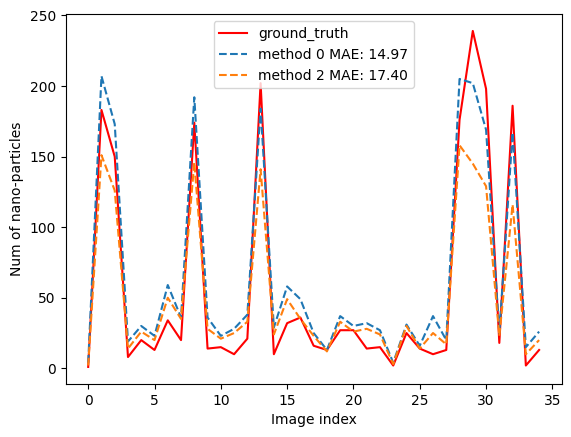

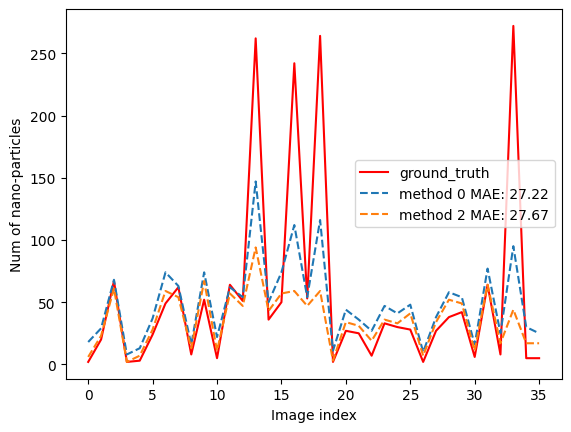

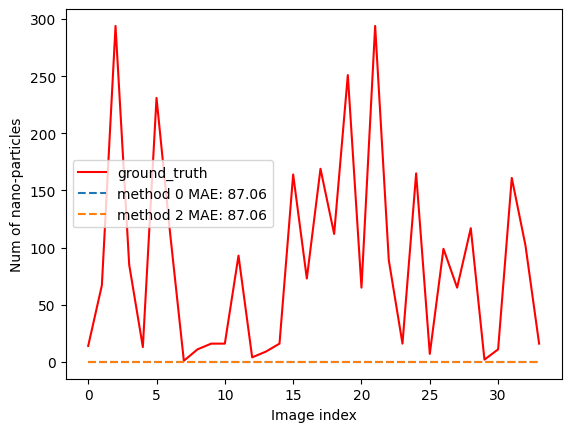

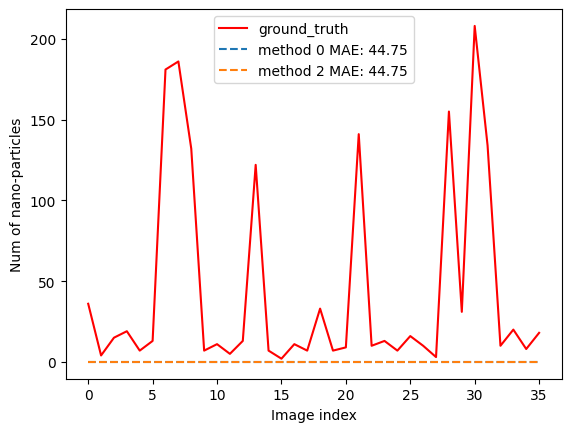

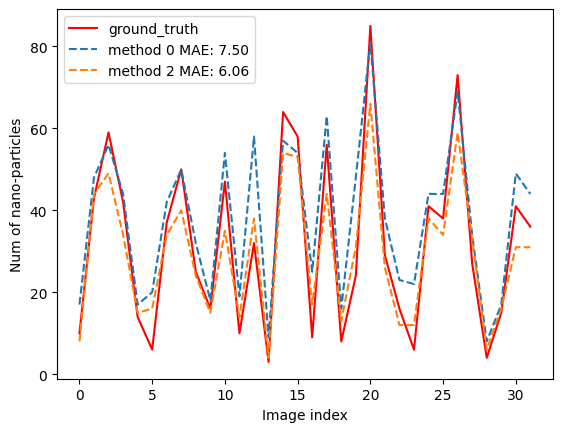

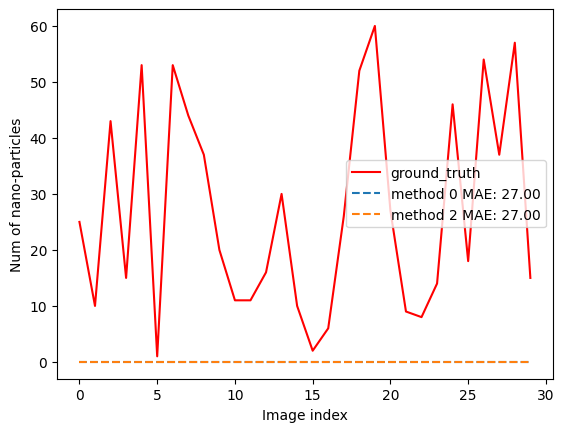

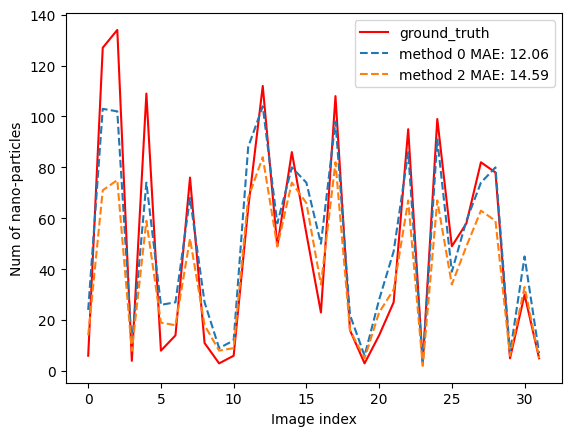

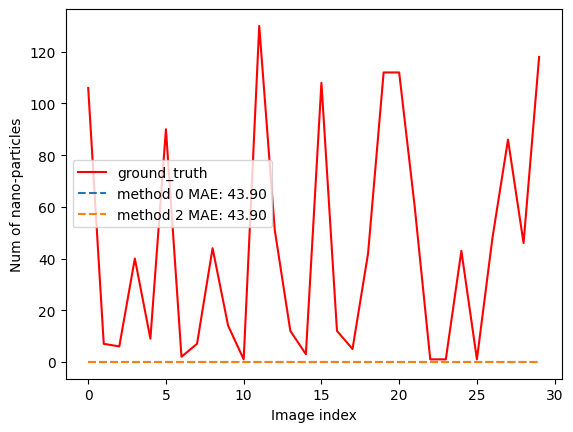

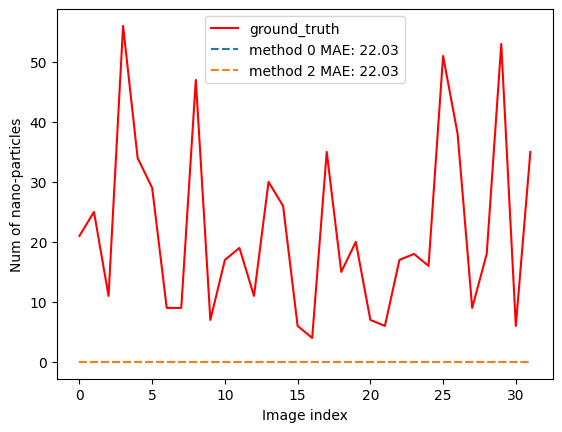

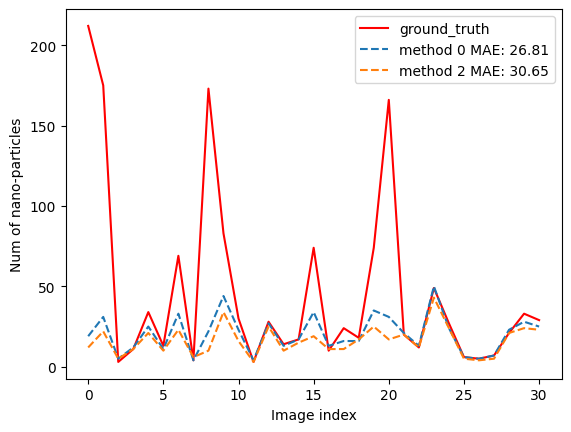

In [24]:
min_dist = 10
max_fil_thr = 120
bin_thr_ = 0.5
range_rad = (10,200)
# type_count = "3" # 4
labels = ["0", "1", "2", "3", "4"]

inp_dir = "/home/huyentn2/project/nano_count/segmentation_unet/data/img_patch/"

save_dir = "/home/huyentn2/project/nano_count/segmentation_unet/output/count_7_4/"

folders = ["fold0","fold1","fold2","fold3","fold4","fold5", "fold6", "fold7", "fold8", "fold9"]
check_dir = "/home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/"
input_dir = "/home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/save_result/gray_pred_inv/"
for f in folders:
    checkpoint_dir = check_dir + f + "/checkpoint_epoch15.pth"

    img_fold = input_dir + f +"/"


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet(n_channels=1, n_classes= 2, bilinear= False)
    model = model.to(memory_format=torch.channels_last)
    model = torch.nn.DataParallel(model).cuda()

    checkpoint = torch.load(checkpoint_dir)


    model.load_state_dict(checkpoint)

    print("loaded ", checkpoint_dir)
    model.to(device=device)

    plot_all_meth(inp_dir, img_fold, save_dir, model, device)


    